# Scikit-learn analysis

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Import transformed data

In [32]:
from utils import read_data

df, X, y = read_data("~/GitHub/3pt-shooting/data/transformed.csv", 'next_3P%')

# keep random state set here
random_state = 41678

display(df.head())

,AGE,FG,FGA,3P,3PA,2P,2PA,2P%,FT,FTA,...,GS,MP,FG%,3P%,eFG%,ORtg_poss,DRtg_poss,TS%,DBPM,SEASON
0,3.141381,6.447306,8.635655,5.013298,6.868285,5.217103,6.839904,0.762888,4.081655,4.290840,...,80,2195,0.416,0.389,0.514,113.0,110.0,0.538,-0.2,2010
1,3.072317,7.915783,10.338418,5.462556,7.530248,6.931301,8.785030,0.788909,6.463304,6.804092,...,0,2460,0.449,0.382,0.523,114.0,110.0,0.573,-1.1,2010
2,3.141381,5.593445,7.324829,3.848501,5.528775,4.904868,6.073178,0.807737,3.583048,3.936497,...,5,1317,0.445,0.337,0.518,117.0,109.0,0.539,-0.6,2010
3,3.036589,8.595238,11.149475,5.052774,7.047299,7.968627,10.118588,0.787299,6.036811,6.455315,...,76,2886,0.458,0.369,0.505,112.0,109.0,0.538,-0.7,2010
4,2.843867,6.709173,8.724141,3.419952,5.091643,6.398828,8.102839,0.789445,5.604079,5.990726,...,81,2468,0.455,0.303,0.485,113.0,107.0,0.540,0.1,2010


Split data into training and test sets, and use pipeline in `utils.py` to create preprocessing pipeline.

In [33]:
from sklearn.model_selection import train_test_split
from utils import pipeline


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
preprocessor = pipeline(X_train)

## Fit models

#### OLS

In [34]:
from sklearn.linear_model import LinearRegression
from utils import scores, model_train

lin = LinearRegression()

param_grid = {
    'model__fit_intercept': [False,True]
}

print('Train:')
ln_reg = model_train(lin, X_train, y_train, preprocessor=preprocessor, param_grid=param_grid)

print()
print('Test:')
scores(ln_reg, X_test, y_test)



Train:
rsquared:	0.287
Mean squared error:	0.001270
Mean absolute error:	0.0277

Test:
rsquared:	0.098
Mean squared error:	0.001486
Mean absolute error:	0.0305


#### Ridge

In [35]:
from sklearn.linear_model import Ridge

param_grid = {
    'model__alpha': np.logspace(-5,5, num=11, endpoint=5, base=10)
}

print('Train:')
ridge = model_train(Ridge(), X_train, y_train, preprocessor=preprocessor, param_grid=param_grid)

print()
print('Test:')
scores(ln_reg, X_test, y_test)

Train:
rsquared:	0.241
Mean squared error:	0.001351
Mean absolute error:	0.0288

Test:
rsquared:	0.098
Mean squared error:	0.001486
Mean absolute error:	0.0305


#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor

# create parameter grid
param_grid = {
    'model__max_depth': [*list(np.linspace(1,3)), None]
}

print('Train:')
tree = model_train(RandomForestRegressor(), X_train, y_train, preprocessor=preprocessor, param_grid=param_grid)

print()
print('Test:')
scores(tree, X_test, y_test)

Train:
rsquared:	0.884
Mean squared error:	0.000206
Mean absolute error:	0.0111

Test:
rsquared:	0.159
Mean squared error:	0.001385
Mean absolute error:	0.0295


#### Dummy Regressor
Show the results of using the mean target as a prediction.

In [30]:
from sklearn.dummy import DummyRegressor

print('Train:')
dummy = model_train(DummyRegressor(), X_train, y_train, preprocessor=preprocessor)

print()
print('Test:')
scores(dummy, X_test, y_test)


rsquared:	0.000
Mean squared error:	0.001721
Mean absolute error:	0.0323
rsquared:	-0.002
Mean squared error:	0.001827
Mean absolute error:	0.0331
None


## Fine Tuning Random Forest

In [37]:
from sklearn.model_selection import RandomizedSearchCV

X_train_scaled = preprocessor.fit_transform(X_train)

random_search = {'criterion': ['squared_error', 'absolute_error', 'poisson'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

reg = RandomForestRegressor()
model = RandomizedSearchCV(estimator = reg, param_distributions = random_search, n_iter = 80, 
                               cv = 4, verbose= 5, random_state= random_state, n_jobs = -1)
model.fit(X_train_scaled,y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=80,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                   

Summarize random search

In [38]:
print(model.best_params_)
print(model.best_score_)
print(model.score(X_train_scaled, y_train))

{'n_estimators': 966, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 1067, 'criterion': 'squared_error'}
0.18206499467820353
0.7740543607478165


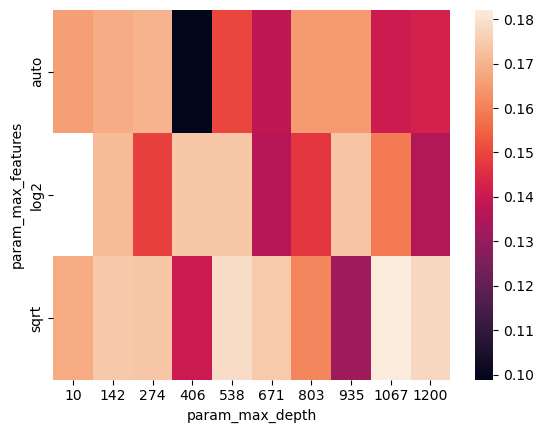

In [39]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_max_features', 
                       columns='param_max_depth')
     
sns.heatmap(table)
plt.show()


In [41]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    'criterion': [model.best_params_['criterion']],
    'max_depth': [model.best_params_['max_depth']],
    'max_features': [model.best_params_['max_features']],
    'min_samples_leaf': [model.best_params_['min_samples_leaf'] - 2, 
                         model.best_params_['min_samples_leaf'], 
                         model.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model.best_params_['min_samples_split'] - 3, 
                          model.best_params_['min_samples_split'], 
                          model.best_params_['min_samples_split'] + 3],
    'n_estimators': [model.best_params_['n_estimators'] - 150, 
                     model.best_params_['n_estimators'] - 100, 
                     model.best_params_['n_estimators'], 
                     model.best_params_['n_estimators'] + 100, 
                     model.best_params_['n_estimators'] + 150]
}

model1 = GridSearchCV(estimator = reg, param_grid = grid_search,  
                               cv = 4, verbose= 5, n_jobs = -1)
model1.fit(X_train_scaled,y_train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [1067],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [816, 866, 966, 1066, 1116]},
             verbose=5)

In [42]:
print(model1.best_params_)
print(model1.best_score_)
print(model1.score(X_train_scaled, y_train))

{'criterion': 'squared_error', 'max_depth': 1067, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 866}
0.18557328374978177
0.8464895706605288


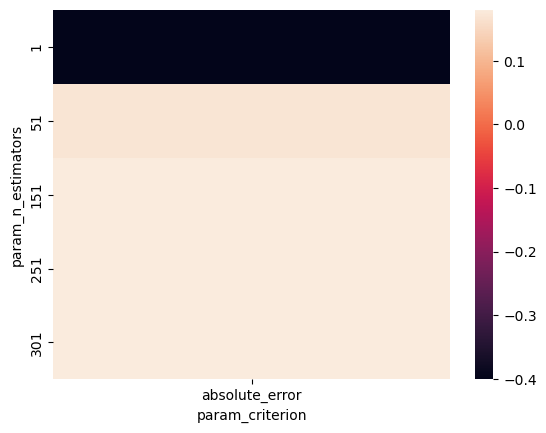

In [34]:
table = pd.pivot_table(pd.DataFrame(model1.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)
plt.show()

In [43]:
grid_search2 = {
    'criterion': [model1.best_params_['criterion']],
    'max_depth': [model1.best_params_['max_depth']],
    'max_features': [model1.best_params_['max_features']],
    'min_samples_leaf': [max(model1.best_params_['min_samples_leaf'] - 2,1), 
                         max(model1.best_params_['min_samples_leaf'] - 1,1 ), 
                         model1.best_params_['min_samples_leaf'], 
                         model1.best_params_['min_samples_leaf'] + 1,
                         model1.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [max(model1.best_params_['min_samples_split'] - 3, 1), 
                          model1.best_params_['min_samples_split'], 
                          model1.best_params_['min_samples_split'] + 3],
    'n_estimators': [model1.best_params_['n_estimators'] - 100, 
                     model1.best_params_['n_estimators'] - 50, 
                     model1.best_params_['n_estimators'], 
                     model1.best_params_['n_estimators'] + 50, 
                     model1.best_params_['n_estimators'] + 100]
}
model2 = GridSearchCV(estimator = reg, param_grid = grid_search2,  
                               cv = 4, verbose= 5, n_jobs = -1)
model2.fit(X_train_scaled,y_train)


Fitting 4 folds for each of 75 candidates, totalling 300 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'max_depth': [1067],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 1, 2, 3, 4],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [766, 816, 866, 916, 966]},
             verbose=5)

In [45]:
print(model2.best_params_)
print(model2.best_score_)
print(model2.score(X_train_scaled, y_train))

{'criterion': 'squared_error', 'max_depth': 1067, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 916}
0.18582450646659662
0.8896575893667829


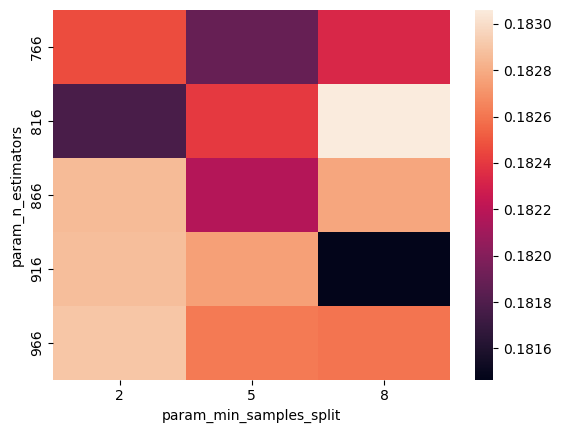

In [46]:
table = pd.pivot_table(pd.DataFrame(model2.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)
plt.show()

In [47]:
reg = RandomForestRegressor(**model2.best_params_)
tree1 = model_train(reg, X_train, y_train, preprocessor=preprocessor)

print(scores(tree1, X_test, y_test))

rsquared:	0.889
Mean squared error:	0.000198
Mean absolute error:	0.0109
rsquared:	0.175
Mean squared error:	0.001359
Mean absolute error:	0.0293
None


## Ridge Regression Parameter Tuning

In [48]:
ridge_search = {
    'alpha':np.logspace(-5, 5),
    'fit_intercept': [ True, False ],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

model = RandomizedSearchCV(estimator = Ridge(), param_distributions = ridge_search, n_iter = 80, 
                               cv = 4, random_state= random_state)
model.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=4, estimator=Ridge(), n_iter=80,
                   param_distributions={'alpha': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705...
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05]),
                                        'fit_intercept': [True, False],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                        

In [49]:
print(model.best_params_)
print(model.best_score_)
print(model.score(X_train_scaled, y_train))

{'solver': 'svd', 'fit_intercept': True, 'alpha': 355.64803062231283}
0.180338495211558
0.22441663087061547


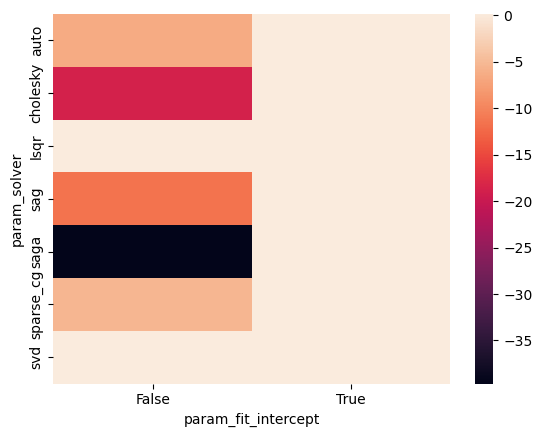

In [50]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_solver', 
                       columns='param_fit_intercept')
     
sns.heatmap(table)
plt.show()

In [51]:
from sklearn.model_selection import GridSearchCV

ridge_search2 = {
    'alpha':np.logspace(-1, 3, 20),
    'fit_intercept': [ True ],
    'solver': ['sag', 'saga']
}

model1 = GridSearchCV(estimator = Ridge(), param_grid = ridge_search2,cv = 4)
model1.fit(X_train_scaled,y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-01, 1.62377674e-01, 2.63665090e-01, 4.28133240e-01,
       6.95192796e-01, 1.12883789e+00, 1.83298071e+00, 2.97635144e+00,
       4.83293024e+00, 7.84759970e+00, 1.27427499e+01, 2.06913808e+01,
       3.35981829e+01, 5.45559478e+01, 8.85866790e+01, 1.43844989e+02,
       2.33572147e+02, 3.79269019e+02, 6.15848211e+02, 1.00000000e+03]),
                         'fit_intercept': [True], 'solver': ['sag', 'saga']})

In [52]:
print(model1.best_params_)
print(model1.best_score_)
print(model1.score(X_train_scaled, y_train))

{'alpha': 233.57214690901213, 'fit_intercept': True, 'solver': 'saga'}
0.18044520786521212
0.22993001820542236


In [53]:
reg = Ridge(**model1.best_params_)
ridge = model_train(reg, X_train, y_train, preprocessor=preprocessor)

scores(ridge, X_test, y_test)

rsquared:	0.230
Mean squared error:	0.001371
Mean absolute error:	0.0290
rsquared:	0.158
Mean squared error:	0.001386
Mean absolute error:	0.0293


## Feature importance

In [54]:
feature_names = list()
feature_names.extend(ridge.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out())
feature_names.extend(ridge.named_steps['preprocessor'].transformers_[1][1].named_steps['scaler'].get_feature_names_out())

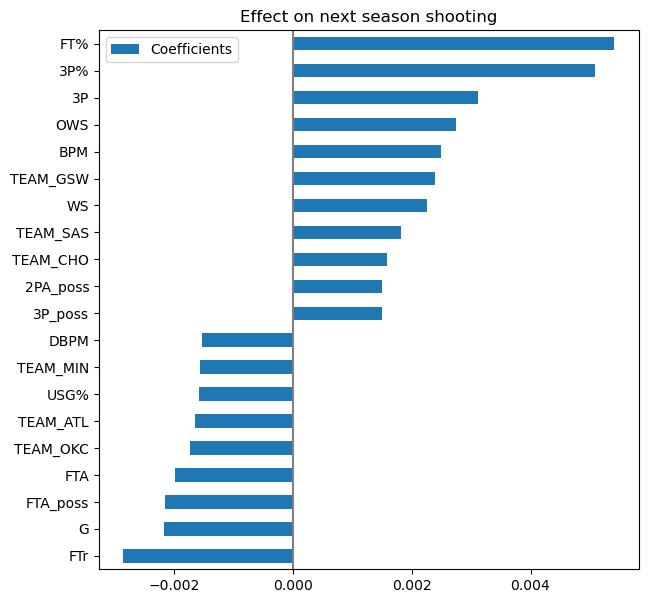

In [55]:
coefs = pd.DataFrame(
    ridge.named_steps['model'].coef_,
    columns=['Coefficients'], index=feature_names
)

coefs['signs'] = np.sign(coefs.Coefficients)
coefs['abs'] = np.abs(coefs.Coefficients)

coefs = coefs.sort_values(by=['abs'], ascending=False)

coefs_20 = coefs.iloc[0:20,:].sort_values(by=['Coefficients'])

coefs_20.plot(y='Coefficients',kind='barh', figsize=(9, 7))
plt.title('Effect on next season shooting')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()

## Random forest feature importance

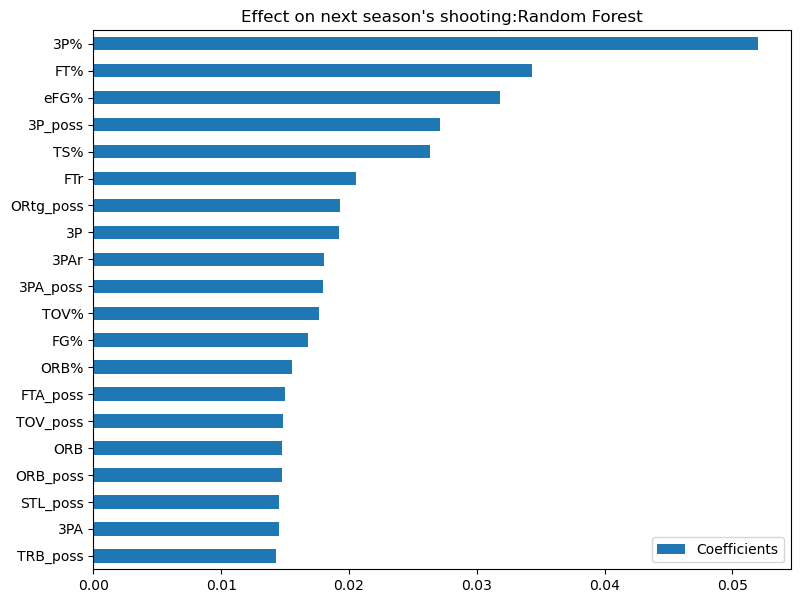

In [56]:
tree_imp = tree1.named_steps['model'].feature_importances_
# tree1.named_steps['model'].estimators_[0]
# std = np.std( [tree.feature_importances_ for tree in tree1.named_steps['model'].estimators_], axis=0 )

coefs_tree = pd.DataFrame(
    tree_imp,
    columns=['Coefficients'], index=feature_names
)

coefs_tree['signs'] = np.sign(coefs_tree.Coefficients)
coefs_tree['abs'] = np.abs(coefs_tree.Coefficients)
coefs_tree['std'] = np.std( [tree.feature_importances_ for tree in tree1.named_steps['model'].estimators_], axis=0 )


coefs_tree = coefs_tree.sort_values(by=['abs'], ascending=False)

coefs_20_tree = coefs_tree.iloc[0:20,:].sort_values(by=['Coefficients'])

coefs_20_tree.plot(y='Coefficients',kind='barh', figsize=(9, 7))
plt.title("Effect on next season's shooting:Random Forest")

plt.show()


## Feature reduction
Let's see how only using the most important features affects model performance in Ridge model.

In [59]:
coefs_20.index

Index(['FTr', 'G', 'FTA_poss', 'FTA', 'TEAM_OKC', 'TEAM_ATL', 'USG%',
       'TEAM_MIN', 'DBPM', '3P_poss', '2PA_poss', 'TEAM_CHO', 'TEAM_SAS', 'WS',
       'TEAM_GSW', 'BPM', 'OWS', '3P', '3P%', 'FT%'],
      dtype='object')

In [60]:
from utils import scores

subset = ['FTr', 'G', 'FTA_poss', 'FTA', 'USG%', 'DBPM', '3P_poss', '2PA_poss', 'TEAM', 'BPM', 'OWS', '3P', '3P%', 'FT%']

pct = X[subset]


lin = Ridge()

x_train, x_test, y_train, y_test = train_test_split(pct, y, random_state=random_state)

pipe = pipeline(x_train)

model = model_train(lin, x_train, y_train, preprocessor=pipe)
scores(model, x_test, y_test)


rsquared:	0.246
Mean squared error:	0.001342
Mean absolute error:	0.0287
rsquared:	0.104
Mean squared error:	0.001475
Mean absolute error:	0.0302
